# RNA-ADT: scButterfly-C

The following tutorial demonstrate how to use scButterfly-C variant with data augmentation using totalVI cluster labels. 

scButterfly-C with totalVI cluster labels data augmentation will generate synthetic paired data by randomly paired scRNA-seq and scADT-seq of different cells with the same cluster labels. [Leiden](https://www.nature.com/articles/s41598-019-41695-z/) is used on the embedding space of [totalVI](https://www.nature.com/articles/s41592-020-01050-x), which is a single-cell multi-omics data joint analysis method in Python packages [scvi-tools](https://docs.scvi-tools.org/en/stable/). The supplement of these generated data will provide scButterfly a better performance of translation, but take more time for training.

<div class="alert note">
<p>

**Note**

Most of this tutorial is same as [scButterfly-C](RNA_ADT_paired_scButterfly-B.ipynb) for RNA and ADT data with more details of data pre-processing, model constructing, model training and evaluating. It's prefered to see that first, because it has no different in parts mentioned above, but have more useful notes.


</p>
</div>

In [1]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

## Train totalVI

To use totalVI augmentation, we should train a totalVI model first.

In [2]:
from scvi_colab import install
install()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import sys
from scButterfly.calculate_cluster import *
import scipy.sparse as sp
from scButterfly.split_datasets import *

# here TotalVI need count matrixs both for RNA and ADT
adata_protein = sc.read_h5ad('CITE_BMMC_ADT.h5ad')
adata_gene = sc.read_h5ad('CITE_BMMC_RNA.h5ad')

sc.pp.highly_variable_genes(adata_gene, batch_key="batch", flavor="seurat_v3", n_top_genes=4000, subset=True)

id_list = five_fold_split_dataset(adata_gene, adata_protein, seed=19191)
train_id, validation_id, test_id = id_list[0]

adata_gene_train = adata_gene[train_id].copy()
adata_protein_train = adata_protein[train_id].copy()

adata_gene_train.obsm['protein_expression'] = adata_protein_train.to_df()

scvi.model.TOTALVI.setup_anndata(adata_gene_train, batch_key="batch", protein_expression_obsm_key="protein_expression")

model = scvi.model.TOTALVI(adata_gene_train, latent_distribution="normal", n_layers_decoder=2)

model.train()

adata_gene_train.obsm["X_totalVI"] = model.get_latent_representation()

leiden_adata = ad.AnnData(adata_gene_train.obsm["X_totalVI"])
sc.pp.neighbors(leiden_adata)
sc.tl.leiden(leiden_adata, resolution=3)

/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
Global seed set to 0
/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experi

INFO     Using column names from columns of adata.obsm['protein_expression']                                       
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 138/138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [15:28<00:00,  6.45s/it, loss=1.63e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=138` reached.


Epoch 138/138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [15:28<00:00,  6.73s/it, loss=1.63e+03, v_num=1]


In [3]:
ADT_data = sc.read_h5ad('CITE_BMMC_ADT.h5ad')
RNA_data = sc.read_h5ad('CITE_BMMC_RNA.h5ad')
ADT_data.X = csr_matrix(ADT_data.X)
RNA_data.X = csr_matrix(RNA_data.X)

In [4]:
RNA_data

AnnData object with n_obs × n_vars = 90261 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
ADT_data

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
from scButterfly.data_processing import RNA_data_preprocessing, CLR_transform

In [7]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=None,
    logging_path=None
    )
ADT_data = CLR_transform(ADT_data)[0]

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.


In [8]:
from scButterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data, ADT_data, seed=19191)
train_id, validation_id, test_id = id_list[0]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

## Data augmentation with cluster labels from totalVI embeddings

In extensive usage, we should explicit randomly generate synthetic paired data with reference of Leiden cluster in totalVI embeddings. You could easily reporduce use the following blocks.

In [9]:
copy_count = 3
random.seed(19193)
cell_type = leiden_adata.obs.leiden
for i in range(len(cell_type.cat.categories)):
    cell_type_name = cell_type.cat.categories[i]
    idx_temp = list(cell_type[cell_type == cell_type_name].index.astype(int))
    for j in range(copy_count - 1):
        random.shuffle(idx_temp)
        for each in idx_temp:
            train_id_r.append(train_id[each])
        random.shuffle(idx_temp)
        for each in idx_temp:
            train_id_a.append(train_id[each])

In [10]:
from scButterfly.train_model_cite import Model
import torch
import torch.nn as nn

In [11]:
RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ADT_input_dim = ADT_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = R_kl_div
kl_div = R_kl_div + A_kl_div

In [12]:
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ADT_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ADT_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Identity()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0,
    chrom_list = [],
    logging_path = None,
    RNA_data = RNA_data,
    ATAC_data = ADT_data
)

Data augmentation will take more time for training.

In [13]:
model.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 2, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_r,
    train_id_a = train_id_a,
    validation_id_r = validation_id_r, 
    validation_id_a = validation_id_a, 
    output_path = None,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = None
)

[INFO] Trainer: RNA pretraining ...
RNA pretrain:  81%|█████████████████▊    | 81/100 [41:37<09:45, 30.84s/it, train=0.0491, val=0.0516]
[INFO] Trainer: ADT pretraining ...
ADT pretrain:  96%|█████████████████████ | 96/100 [45:46<01:54, 28.61s/it, train=0.0578, val=0.0810]
[INFO] Trainer: Combine training ...
Combine training:  32%|████▏        | 64/200 [2:43:51<5:48:11, 153.61s/it, train=0.5682, val=0.6287]


In [14]:
A2R_predict, R2A_predict = model.test(
    test_id_r = test_id_r,
    test_id_a = test_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_cluster = False,
    test_figure = False,
    output_data = False,
    return_predict = True
)

[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████| 283/283 [00:04<00:00, 69.44it/s]
[INFO] Tester: calculate neighbors graph for following test ...


In [15]:
from scButterfly.calculate_cluster import calculate_cluster_index

scButterfly-C with data augmentation usually get a better performance compare to [scButterfly-B](RNA_ADT_paired_scButterfly-B.ipynb). However, the performance of totalVI augmentation often slightly worse than data augmentation with cell-type labels. We recommend the [scButterfly-T](RNA_ADT_paired_scButterfly-T.ipynb) when there has ``RNA_data.obs["cell_type"]`` and ``ADT_data.obs["cell_type"]``.

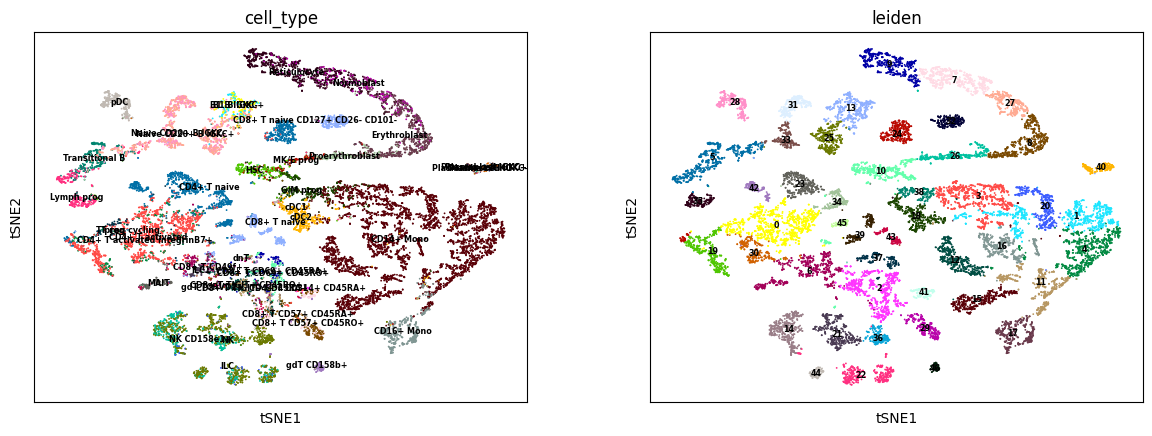

In [16]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='xx-small')

In [17]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ADT to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ADT to RNA:
ARI: 0.276, 	AMI: 0.683, 	NMI: 0.689, 	HOM: 0.761, 	COM: 0.629


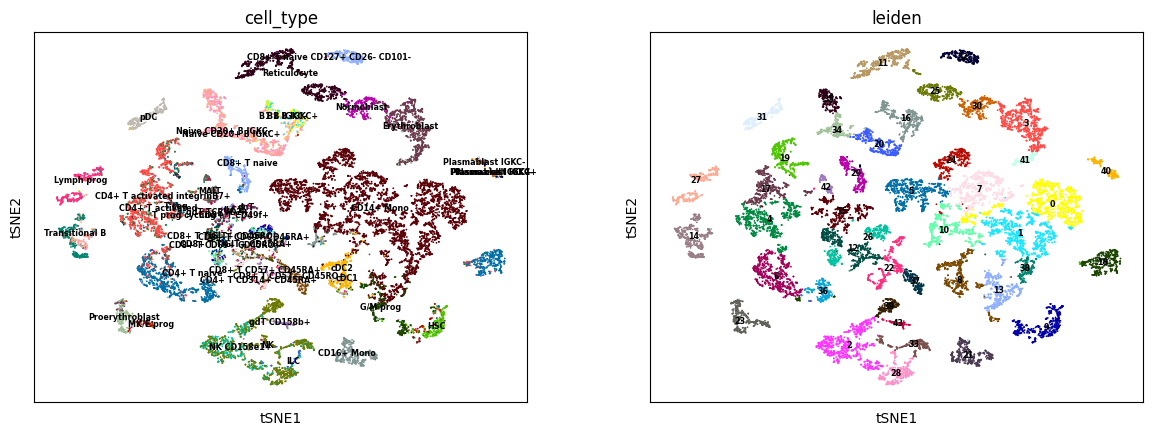

In [18]:
sc.tl.tsne(R2A_predict)
sc.tl.leiden(R2A_predict)
sc.pl.tsne(R2A_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='xx-small')

In [19]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ADT:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ADT:
ARI: 0.321, 	AMI: 0.708, 	NMI: 0.713, 	HOM: 0.783, 	COM: 0.654
